In [1]:
import pandas as pd

user_behavior = pd.read_csv('~/Downloads/UserBehavior.csv',header=None,iterator=True)
#数据太多，先获取前一万条
head_data = user_behavior.get_chunk(10000)
head_data.head()

,0,1,2,3,4
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146


In [2]:
#对数据进行整理清洗
#添加列名，分别是：用户id，商品id，商品类目id，行为类型，时间戳
head_data.columns = ['user_id','goods_id','category_id','behavior','timestamp']

In [3]:
#利用pandas的接口查看是否有空值
head_data.isnull().any()

user_id        False
goods_id       False
category_id    False
behavior       False
timestamp      False
dtype: bool

In [4]:
#将时间戳转化为时间格式，新加一列time，删除时间戳
head_data['time'] = pd.to_datetime(head_data['timestamp'],unit='s')
head_data = head_data.drop(['timestamp'],axis=1)

In [5]:
#将time字段设为索引，为了方便清除异常时间的数据
head_data.set_index('time',inplace=True)
head_data.head()

,user_id,goods_id,category_id,behavior
time,,,,
2017-11-24 17:21:10,1,2268318,2520377,pv
2017-11-24 22:15:33,1,2333346,2520771,pv
2017-11-25 01:21:25,1,2576651,149192,pv
2017-11-25 07:04:53,1,3830808,4181361,pv
2017-11-25 07:49:06,1,4365585,2520377,pv


In [6]:
#选取2017年11月25日至2017年12月3日的数据
head_data = head_data['2017-11-25':'2017-12-03']

/var/folders/7g/4v_spkd94zl1056n5_0bzy8m0000gn/T/ipykernel_22284/403382749.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  head_data = head_data['2017-11-25':'2017-12-03']


In [7]:
#需求1：统计用户的每个购物行为
count_by_user_behave = head_data.groupby(['user_id','behavior']).count()
count_by_user_behave.head()

goods_id  category_id
user_id behavior                       
1       pv              53           53
100     buy              8            8
        fav              3            3
        pv              72           72
1000    cart             1            1

In [8]:
count_by_user_behave = count_by_user_behave['goods_id']
count_by_user_behave.head()

user_id  behavior
1        pv          53
100      buy          8
         fav          3
         pv          72
1000     cart         1
Name: goods_id, dtype: int64

<AxesSubplot:xlabel='user_id,behavior'>

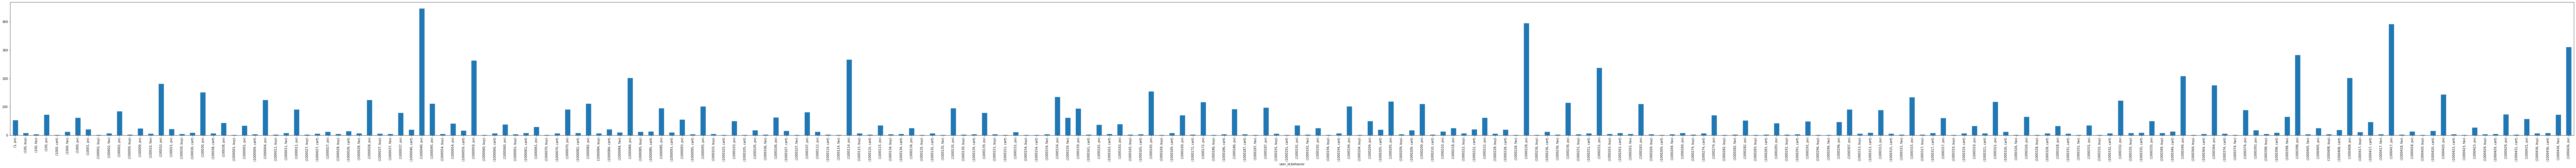

In [9]:
#使用pandas自带的画图功能
import matplotlib.pyplot as plt
count_by_user_behave.plot(kind='bar',figsize=(150,8))

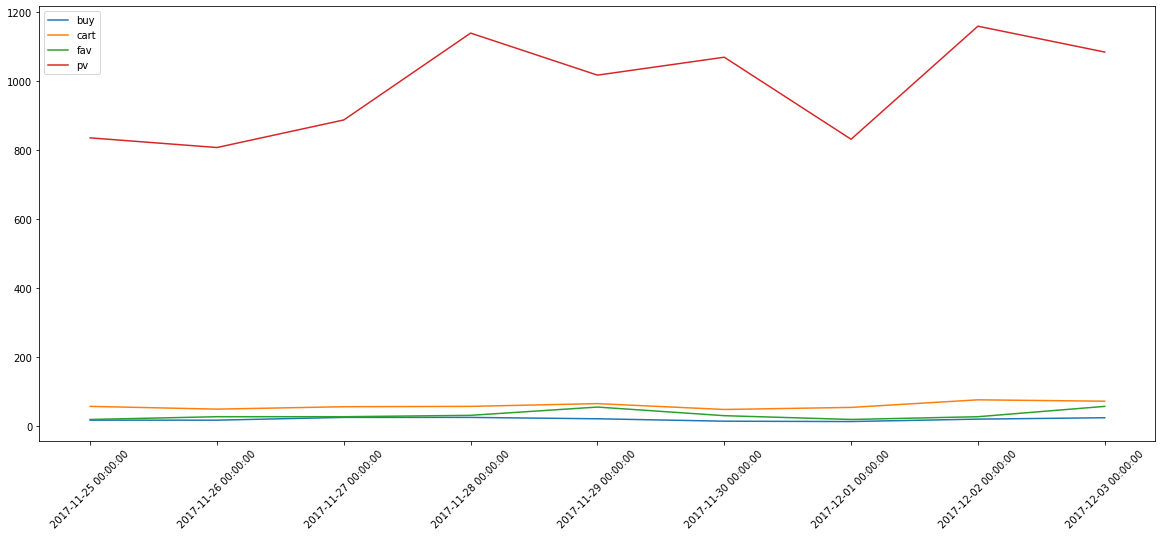

In [10]:
#需求2：统计每天各行为的访问次数
import matplotlib.pyplot as plt
%matplotlib inline
#设置画布大小
plt.figure(figsize=(20,8))

for group_name,group_data in head_data.groupby('behavior'):
    
    #对每天的行为进行统计
    count_by_day = group_data['behavior'].resample('D').count()
    
    x = count_by_day.index
    y = count_by_day.values
    
    #设置x，y轴数据
    plt.plot(range(len(x)),y,label=group_name)

#设置x轴的刻标以及对应的标签    
plt.xticks(range(len(x)),x,rotation=45)

#自适应位置
plt.legend(loc='best')
plt.show()

In [11]:
#需求3：找出购买率最高的前二十个商品品类，并以柱状图展示

#取消时间索引
head_data = head_data.reset_index()

#按商品种类分组
count_by_category_id = head_data.groupby('category_id')

#分组后每组数据的数量
count_by_category_id.size()

category_id
8254        2
16219       5
22129       1
35290      16
48094       1
           ..
5071267    16
5091223     2
5103246     1
5140516     1
5150761     1
Length: 942, dtype: int64

In [12]:
con_dict = {}
for group_name,group_data in count_by_category_id:
    #总次数,获取的总行数为总次数
    total = group_data.shape[0]
    buy = 0
    try:
        #有些商品没有购买行为，以buy作为索引获取时会出错，使用异常语句捕捉一下
        buy = group_data.groupby('behavior').size()['buy']
    except:
        pass
    
    #转化率
    convention = buy/total*100
    
    #类别名称对应转化率
    con_dict[group_name] = convention
    
#排序
sort_con = sorted(con_dict.items(),key=lambda item:item[1],reverse=True)

#对排好序的列表取值
sort_con_20 = sort_con[:20]
sort_con_20

[(895939, 100.0),
 (1597811, 100.0),
 (1833532, 100.0),
 (2550060, 100.0),
 (2895013, 100.0),
 (2951233, 100.0),
 (2975713, 100.0),
 (4238377, 100.0),
 (4242742, 100.0),
 (4470576, 100.0),
 (4718844, 100.0),
 (890050, 60.0),
 (835895, 55.55555555555556),
 (512076, 50.0),
 (1879672, 50.0),
 (3025028, 50.0),
 (3445085, 50.0),
 (3695050, 50.0),
 (3797203, 50.0),
 (1601543, 40.0)]

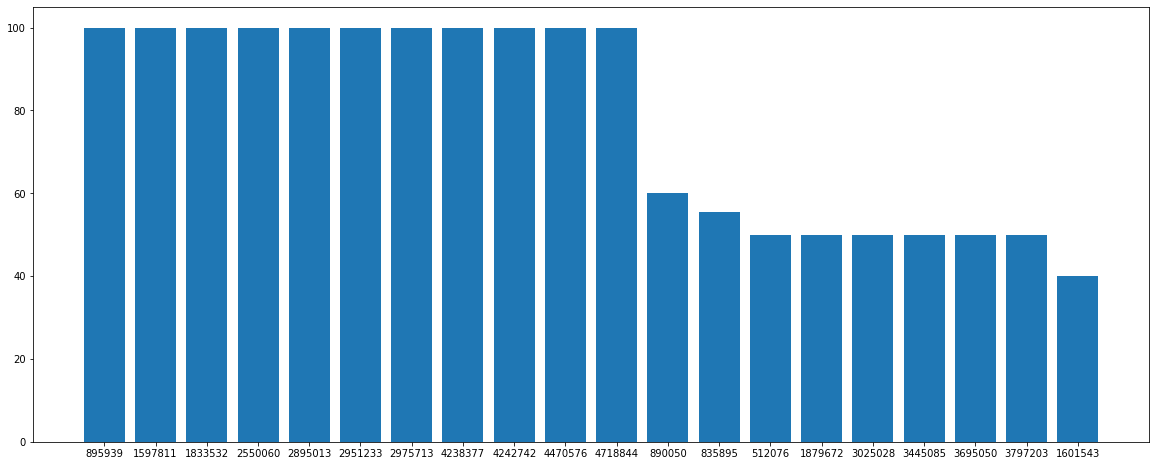

In [13]:
#获取所有的商品种类
tick_label = [i[0] for i in sort_con_20]

#获取转化率
num_list = [i[1] for i in sort_con_20]

#开始画图
plt.figure(figsize=(20,8))
plt.bar(range(len(sort_con_20)),num_list,tick_label=tick_label)
plt.show()